# APP1-Vents

## Resonance frequency

For a cylindrical tube with length $L$ and radius $a$, assume the input mechanical impedance at $x=0$ is $Z_{m,0}$ and output impedance at $x=L$ is $Z_{m,L}$. The relation between $Z_{m,0}$ and $Z_{m,L}$ is given by
$$
    Z_{m,0} = \frac{\rho_0 c_0}{S} \frac{Z_{m,L} + j \frac{\rho_0 c_0}{S} \tan(kL)}{\frac{\rho_0 c_0}{S} + j Z_{m,L} \tan(kL)}
$$
where $S$ is the cross-sectional area of the duct, $\rho_0$ is the air density, $c_0$ is the speed of sound, and $k$ is the wave number. From this equation, the input impedance depends on the output impedance(load impedance) as well as the length of the tube. Resonance frequency is given by
$$
    f = \text{argmax}_{f}(Z_{m,0}) 
$$

Known that usually $Z_{m,L} \neq 0$ since the tube radiates sound tinto the surrounding, assume that $Z_{m,L} = Z_r$ where $Z_r$ is the radiation impedance. In a radiation model, for a flanged tube (output is an infinite plane), $Z_r = \frac{\rho_0 c_0}{S} \frac{(ka^2)}{2} + j \frac{\rho_0 c_0}{S} \frac{8ka}{3\pi}$; for a unflanged tube, $Z_r = \frac{\rho_0 c_0}{S} \frac{(ka^2)}{4} + j \frac{\rho_0 c_0}{S} 0.6 ka$;
for a closed tube, $Z_r = \infty$.

Under a flanged tube condition, the resonance frequency could be solved by
$$
    \tan(n\pi - k_nL) = \frac{8ka}{3\pi} =  \tan(\frac{8ka}{3\pi})
$$
so that $f_n = \frac{n}{2} \frac{c_0}{L + \frac{8a}{3\pi}}$. The effective length of the tube is $L_{eff} = L + \frac{8a}{3\pi}$. Note that $L_{eff} = L + \Delta L$, $\Delta L = \frac{8a}{3\pi}$ is called end correction. This $\Delta L$ is caused by the additional mass $\mathcal{Im}(Z_r)$ at the end of the tube.

Under a unflanged tube condition, the effective length of the tube is $L_{eff} = L + 0.6a$. This result is obtained only for the tibe with constant cross-sectional area.


For a conical tube, the relation of impedance follows
\begin{align*}
    \begin{bmatrix}
        p_1\\
        u_1
    \end{bmatrix}
    =
    \begin{bmatrix}
        A & B \\ C & D
    \end{bmatrix}
    \begin{bmatrix}
        p_2\\
        u_2
    \end{bmatrix}
\end{align*}
where 
\begin{align*}
    A &= \frac{R_2}{R_1} \cos(kL) - \frac{\sin(kL)}{kx_1}\\
    B &= j\frac{\rho_0 c_0}{\pi R_1 R_2}\sin(kL)\\
    C &= \frac{\pi R_1 R_2}{\rho_0 c_0}\left( j \sin(kL) \left( 1 + \frac{1}{k^2x_1 x_2}\right) + \frac{\cos(kL)}{jk}\left(\frac{1}{x_1}-\frac{1}{x_2}\right) \right)\\
    D &= \frac{R_1}{R_2}\cos(kL) + \frac{\sin(kL)}{kx_2}
\end{align*}
and $Z_{m,i} = \frac{p_i}{u_i}$. The cylindrical tube is a special case of the conical tube with $R_1 = R_2 = a$ and $x_1 = x_2 = \infty$.

## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks


## Parameters

In [20]:
# load Pabsc and Prayon
Pabsc = np.loadtxt('Pabsc.csv')
Prayon = np.loadtxt('Prayon.csv')

# parameters
config = {
    'speed of sound': 343.0,    # m/s
    'density of air': 1.2,      # kg/m^3
}

In [21]:
c0 = config['speed of sound']
rho0 = config['density of air']

## Geometry Model of Trompette

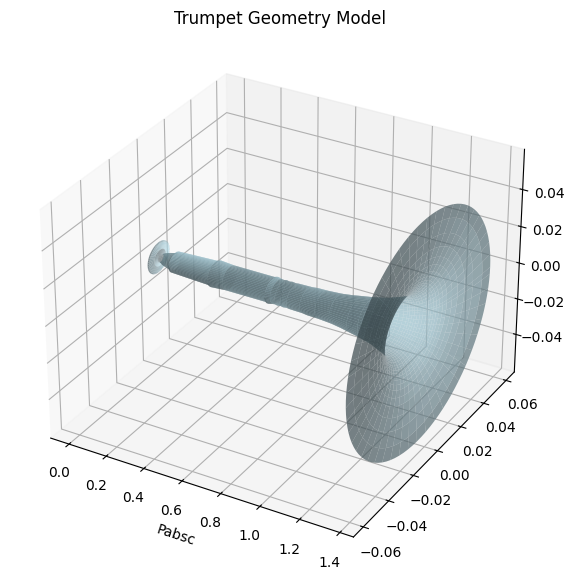

In [ ]:
theta = np.linspace(0, 2 * np.pi, 100)

Pabsc_grid, theta_grid = np.meshgrid(Pabsc, theta)
Prayon_grid = np.tile(Prayon, (100, 1))

X = Pabsc_grid
Y = Prayon_grid * np.cos(theta_grid)
Z = Prayon_grid * np.sin(theta_grid)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, color='lightblue', alpha=0.7)

ax.set_xlabel('Pabsc')
ax.set_title('Trumpet Geometry Model')
plt.show()

## Compute the function of input impedance

In [ ]:
def transfer_function(Z2, x1, x2, R1, R2, k):
# Note that x1 and x2 are the real positions, not the length of the apex to the x

    l = x2 - x1

    # case divergence
    if R1 < R2:
        x1 = R1 * l / (R2 - R1)
        x2 = x1 + l
    # case convergence
    elif R1 > R2:
        x2 = - R2 * l / (R1 - R2)
        x1 = x2 - l
    # case straight
    else:
        x1, x2 = np.inf, np.inf

    A = R2 / R1 * np.cos(k * l) - np.sin(k * l) / (k * x1)
    B = 1j * rho0 * c0 * np.sin(k * l) / (np.pi * R1 * R2)
    C = np.pi * R1 * R2 / (rho0 * c0) * (1j * np.sin(k * l) * (1 + 1 / (k**2 * x1 * x2)) + np.cos(k * l) / (1j * k) * (1 / x1 - 1 / x2))
    D = R1 / R2 * np.cos(k * l) + np.sin(k * l) / (k * x2)

    Z1 = (A * Z2 + B) / (C * Z2 + D)
    return Z1

In [ ]:
def transfer_function_continues(Z2, x, R, k):
# x: array of positions
# R: array of radius of curvature
    for idx in range(len(x) - 1, 0, -1):
        x2 = x[idx]
        R2 = R[idx]
        x1 = x[idx - 1]
        R1 = R[idx - 1]

        Z2 = transfer_function(Z2, x1, x2, R1, R2, k)

    return Z2

For a fringed tube:

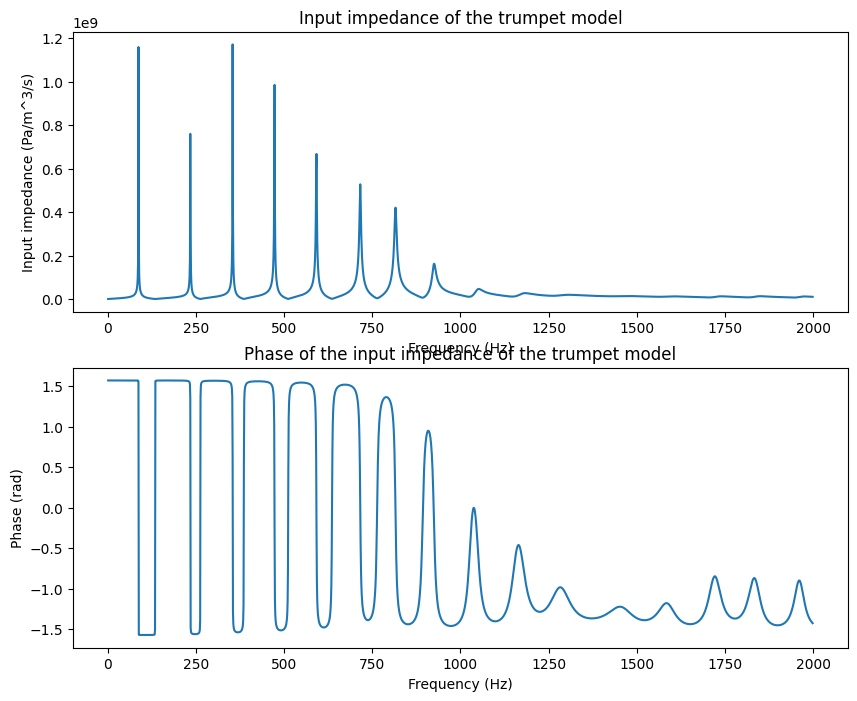

In [102]:
a = Prayon[-1]
S = np.pi * a**2
Z_input = []
freqs = np.arange(1, 2000, 1)

for freq in freqs:
    k = 2 * np.pi * freq / c0
    Zr = rho0 * c0 / S * (k * a)**2 / 2 + 1j * rho0 * c0 / S * (8 * k * a / (3 * np.pi))

    Z0 = transfer_function_continues(Zr, Pabsc, Prayon, k)
    Z_input.append(Z0)
    # print(f"k = {k}, Z0 = {Z0}")

fig, ax = plt.subplots(2, 1, figsize=(10, 8))
ax[0].plot(freqs, np.abs(Z_input))
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Input impedance (Pa/m^3/s)')
ax[0].set_title('Input impedance of the trumpet model')

ax[1].plot(freqs, np.angle(Z_input))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Phase (rad)')
ax[1].set_title('Phase of the input impedance of the trumpet model')
plt.show()



[  87  234  354  473  592  716  816  925 1052 1184 1307 1475 1604 1740
 1851 1976]


In [103]:
# find resonance frequencies
peaks, _ = find_peaks(np.abs(Z_input))
freq_resonances = freqs[peaks]

for idx in peaks:
    print(f"Frequency \t {freqs[idx]} \t Impedance \t {np.abs(Z_input[idx]):.4e}")

Frequency 	 87 	 Impedance 	 1.1598e+09
Frequency 	 234 	 Impedance 	 7.6008e+08
Frequency 	 354 	 Impedance 	 1.1717e+09
Frequency 	 473 	 Impedance 	 9.8554e+08
Frequency 	 592 	 Impedance 	 6.6754e+08
Frequency 	 716 	 Impedance 	 5.2780e+08
Frequency 	 816 	 Impedance 	 4.2033e+08
Frequency 	 925 	 Impedance 	 1.6181e+08
Frequency 	 1052 	 Impedance 	 4.6182e+07
Frequency 	 1184 	 Impedance 	 2.7079e+07
Frequency 	 1307 	 Impedance 	 1.9364e+07
Frequency 	 1475 	 Impedance 	 1.3581e+07
Frequency 	 1604 	 Impedance 	 1.2168e+07
Frequency 	 1740 	 Impedance 	 1.2406e+07
Frequency 	 1851 	 Impedance 	 1.2923e+07
Frequency 	 1976 	 Impedance 	 1.1684e+07
